**Preparing data:** Run the next cells to download and prepare the datasets and util functions.

In [0]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [0]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann-predict-future-sales/master/init.py
    from init import download_utils, unzip_sales_dataset, dataset_dir
    download_utils(force_download=True)

In [ ]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo" -O local/datasets/sales.zip && rm -rf /tmp/cookies.txt

In [0]:
if download_data:
    unzip_sales_dataset()

**Libraries**

In [0]:
import random
import numpy as np
import progressbar
import pandas as pd
import matplotlib.pyplot as plt
import local.lib as lib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, RepeatVector, TimeDistributed, LSTM, GRU

from init import dataset_dir

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
_, signals = lib.get_base_dataset(dataset_dir)

In [0]:
month_to_predict = 4
look_back = 3

In [0]:
signals = signals[:int(10734/2)]

In [0]:
results = {}
summary = []

for signal in progressbar.ProgressBar()(signals):
    results.update({signal:{}})
    
    X_train, y_train, i_train, X_test, y_test, i_test = lib.get_split_signal_data(signal, month_to_predict, 
                                                                              look_back, dataset_dir,
                                                                              reshape=True)
    
    
    
    model = Sequential()
    model.add(SimpleRNN(20, activation = 'relu', input_shape=(1, look_back), return_sequences=True))
    model.add(SimpleRNN(5, activation = 'relu'))
    model.add(Dense(1))
  
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, verbose=0, epochs=10)
    

    tr_pred = model.predict(X_train)
    ts_pred = model.predict(X_test)
    
    results[signal].update({"train":tr_pred})
    results[signal].update({"test":ts_pred})
    
    tr_rmse = np.sqrt(((y_train - tr_pred)**2).mean())
    ts_rmse = np.sqrt(((y_test - ts_pred)**2).mean())
    
    summary.append([tr_rmse, ts_rmse])

100% (5367 of 5367) |####################| Elapsed Time: 3:51:01 Time:  3:51:01


In [0]:
summary = pd.DataFrame(summary, columns=["train", "test"], index=signals)


Text(0.5, 0, 'rsme')

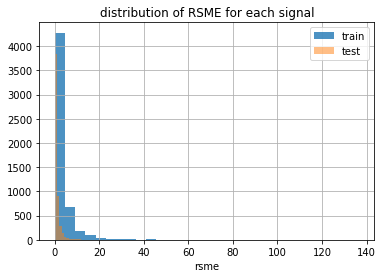

In [0]:
summary.train.hist(bins=30, alpha=0.8, label="train")
summary.test.hist(bins=30, alpha=0.5, label="test")
plt.title("distribution of RSME for each signal")
plt.legend()
plt.xlabel("rsme")

In [0]:
summary.mean()

train    3.748546
test     0.984106
dtype: float64